In [1]:
# Cell 1: Imports and Initial Configuration
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib # For loading the scaler
import matplotlib.pyplot as plt
import json # For saving/loading hyperparameters

# PyTorch Geometric for GNNs
from torch_geometric.nn import GCNConv

# Optuna for hyperparameter tuning
import optuna
import logging # For Optuna logging
import sys     # For Optuna logging

# --- Configuration ---
# !!! IMPORTANT: UPDATE THIS PATH if different from Notebook 04 !!!
model_ready_data_dir = r'D:\.Study\projects\EnergyForecasting\src\model_ready'

# --- NEW SCALER FILENAME (from your multi-year Notebook 04) ---
# This scaler will be loaded if you do post-training evaluation in original scale.
# The model itself trains on already scaled data.
SCALER_FILENAME_MULTIYEAR = 'feature_scaler_multiyear.joblib'
scaler_path_multiyear = os.path.join(model_ready_data_dir, SCALER_FILENAME_MULTIYEAR)


# --- FIXED PARAMETERS ---
INPUT_SEQ_LEN = 24
PREDICTION_HORIZON = 1
NUM_EPOCHS_OPTUNA = 20 # MODIFIED: Reduced for faster initial Optuna runs on new data
                       # Adjust as needed (e.g., 10-25)
FIXED_DROPOUT_RATE = 0.2

# --- PJM Zones (MUST MATCH NOTEBOOK 04 PJM_ZONES_UPPER) ---
zone_identifiers = ['DOM', 'PN', 'PEPCO', 'AECO', 'PE'] # !!! UPDATE IF YOUR LIST CHANGED (e.g. PEPCO, AECO) !!!
num_nodes = len(zone_identifiers)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

target_column_template = '{ZONE}_Load'

def set_seeds(seed_value=42):
    torch.manual_seed(seed_value)
    np.random.seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
set_seeds()

# Global variables for data
train_scaled_df, val_scaled_df = None, None
X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = None, None, None, None
num_all_features_in_df = 0
num_features_per_node_slice_FOR_GNN = 0
common_time_features_gnn_for_init = []
edge_index = None

Using device: cuda


In [2]:
# Cell 2: Graph Definition
# (This cell defines the global `edge_index`)

# DOM: 0, PN: 1, PEPCO: 2, AECO: 3, PE: 4  <--- IMPORTANT: Check this mapping with Cell 1's zone_identifiers
edge_list_tuples = [
    (0, 2), # DOM - PEPCO
    (0, 4), # DOM - PE
    (1, 4), # PN  - PE
    (4, 2), # PE  - PEPCO
    (4, 3), # PE  - AECO
    (2, 3), # PEPCO - AECO
]
undirected_edge_list = []
for u, v in edge_list_tuples:
    undirected_edge_list.append((u, v))
    undirected_edge_list.append((v, u))
for i in range(num_nodes): # Self-loops
    undirected_edge_list.append((i, i))

unique_edges = sorted(list(set(undirected_edge_list)))
edge_index = torch.tensor(unique_edges, dtype=torch.long).t().contiguous().to(device)

print(f"Number of nodes (zones from Cell 1): {num_nodes} ({zone_identifiers})") # Verify
print(f"Edge index shape: {edge_index.shape}")

Number of nodes (zones from Cell 1): 5 (['DOM', 'PN', 'PEPCO', 'AECO', 'PE'])
Edge index shape: torch.Size([2, 17])


In [7]:
# Cell 3: Data Loading and Preprocessing (CORRECTED to include X_test_tensor)

import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset # DataLoader is used later

# Using global keyword to modify variables defined in Cell 1
# These should be declared at the start of the cell for clarity if assigned at top level
global train_scaled_df, val_scaled_df, test_scaled_df # Added test_scaled_df
global X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor # Added X_test_tensor, y_test_tensor
global num_all_features_in_df, num_features_per_node_slice_FOR_GNN
global common_time_features_gnn_for_init
# Ensure model_ready_data_dir, INPUT_SEQ_LEN, PREDICTION_HORIZON, target_column_template, zone_identifiers are global from Cell 1

# --- FILENAMES FOR SCALED MULTIYEAR DATA ---
TRAIN_SCALED_FILENAME = 'train_scaled_multiyear.csv'
VAL_SCALED_FILENAME = 'val_scaled_multiyear.csv'
TEST_SCALED_FILENAME = 'test_scaled_multiyear.csv' # UNCOMMENTED AND USED

try:
    train_scaled_df = pd.read_csv(os.path.join(model_ready_data_dir, TRAIN_SCALED_FILENAME), index_col=0, parse_dates=True)
    val_scaled_df = pd.read_csv(os.path.join(model_ready_data_dir, VAL_SCALED_FILENAME), index_col=0, parse_dates=True)
    test_scaled_df = pd.read_csv(os.path.join(model_ready_data_dir, TEST_SCALED_FILENAME), index_col=0, parse_dates=True) # ADDED LOADING OF TEST DATA
    print(f"Loaded scaled data files: {TRAIN_SCALED_FILENAME}, {VAL_SCALED_FILENAME}, {TEST_SCALED_FILENAME}")
    print(f"  Train scaled shape: {train_scaled_df.shape}")
    print(f"  Val scaled shape:   {val_scaled_df.shape}")
    print(f"  Test scaled shape:  {test_scaled_df.shape}") # ADDED PRINT FOR TEST SHAPE
except FileNotFoundError as e:
    print(f"ERROR: Scaled data file(s) not found in {model_ready_data_dir}. Missing: {e.filename}")
    raise
except Exception as e:
    print(f"An error occurred loading scaled data: {e}")
    raise


def create_sequences(input_data_df, input_seq_len, pred_horizon, target_cols_template, all_zones_list):
    X_list, y_list = [], []
    if input_data_df is None or input_data_df.empty: # Add check for empty df
        print(f"Warning: input_data_df to create_sequences is empty or None. Returning empty arrays.")
        return np.array(X_list), np.array(y_list)
    for i in range(len(input_data_df) - input_seq_len - pred_horizon + 1):
        X_list.append(input_data_df.iloc[i : i + input_seq_len].values)
        targets_current_step = []
        for zone_s in all_zones_list:
            target_col_name = target_cols_template.replace('{ZONE}', zone_s)
            try:
                target_val = input_data_df[target_col_name].iloc[i + input_seq_len + pred_horizon - 1]
                targets_current_step.append(target_val)
            except KeyError:
                print(f"KeyError in create_sequences: Column '{target_col_name}' not found in input_data_df. Skipping this target for this sequence.")
                # Decide how to handle: append NaN, skip sequence, or raise error. For now, let's say this sequence might be incomplete for this zone.
                # This error should ideally be caught by checking zone_identifiers against df columns earlier.
                targets_current_step.append(np.nan) # Or some other placeholder / error handling
        y_list.append(targets_current_step)
    return np.array(X_list), np.array(y_list)

# This block calculates parameters based on train_scaled_df, which is fine.
if not train_scaled_df.empty:
    all_cols_in_df = train_scaled_df.columns.tolist()
    common_time_features_gnn_for_init = [col for col in all_cols_in_df if not any(zone_ident in col for zone_ident in zone_identifiers)] # zone_identifiers from Cell 1
    if not zone_identifiers:
        raise ValueError("zone_identifiers list (from Cell 1) is empty.")
    first_zone_specific_features = [col for col in all_cols_in_df if col.startswith(zone_identifiers[0] + "_")]
    num_features_per_node_slice_FOR_GNN = len(first_zone_specific_features) + len(common_time_features_gnn_for_init)
    print(f"Number of common time features: {len(common_time_features_gnn_for_init)}")
    print(f"Number of specific features for first zone '{zone_identifiers[0]}': {len(first_zone_specific_features)}")
    print(f"Total num_features_per_node_slice (FOR GNN INPUT at each time step): {num_features_per_node_slice_FOR_GNN}")
    if num_features_per_node_slice_FOR_GNN == len(common_time_features_gnn_for_init) and len(first_zone_specific_features) == 0 :
        print(f"WARNING: No specific features found for zone '{zone_identifiers[0]}'. Check column naming and zone_identifiers list.")
else:
    raise ValueError("train_scaled_df is empty. Cannot proceed with parameter calculation.")

# Create sequences for train and validation sets
# Ensure global INPUT_SEQ_LEN, PREDICTION_HORIZON, target_column_template, zone_identifiers are available from Cell 1
X_train, y_train = create_sequences(train_scaled_df, INPUT_SEQ_LEN, PREDICTION_HORIZON, target_column_template, zone_identifiers)
X_val, y_val = create_sequences(val_scaled_df, INPUT_SEQ_LEN, PREDICTION_HORIZON, target_column_template, zone_identifiers)

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# +++ ADDED SECTION TO CREATE X_test_tensor and y_test_tensor +++
if test_scaled_df is not None and not test_scaled_df.empty:
    print("\nCreating sequences for test set...")
    try:
        X_test, y_test = create_sequences(test_scaled_df, INPUT_SEQ_LEN, PREDICTION_HORIZON, target_column_template, zone_identifiers)
        if X_test.size == 0: # Check if create_sequences returned empty arrays (e.g., df too short)
            print("Warning: X_test is empty after create_sequences. test_scaled_df might be too short or have issues.")
            X_test_tensor = None # Explicitly set to None
            y_test_tensor = None # Explicitly set to None
        else:
            X_test_tensor = torch.from_numpy(X_test).float()
            y_test_tensor = torch.from_numpy(y_test).float()
            print(f"X_test_tensor created with shape: {X_test_tensor.shape}")
            print(f"y_test_tensor created with shape: {y_test_tensor.shape}")
    except KeyError as e_key_test:
        print(f"KeyError during test sequence creation: {e_key_test}. This means `zone_identifiers` might not match columns in `test_scaled_multiyear.csv`.")
        print(f"  Problematic column: {e_key_test}")
        print(f"  Current zone_identifiers: {zone_identifiers}")
        print(f"  Columns in test_scaled_df: {list(test_scaled_df.columns)}")
        X_test_tensor = None
        y_test_tensor = None
    except Exception as e_general_test:
        print(f"An unexpected error occurred during test sequence creation: {e_general_test}")
        X_test_tensor = None
        y_test_tensor = None
else:
    print("Warning: test_scaled_df is None or empty. X_test_tensor and y_test_tensor will not be created.")
    X_test_tensor = None
    y_test_tensor = None
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


num_all_features_in_df = train_scaled_df.shape[1] # Based on train_scaled_df
print(f"\nShapes of sequence data (Tensors):")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_val_tensor shape:   {X_val_tensor.shape}")
print(f"y_val_tensor shape:   {y_val_tensor.shape}")
# X_test_tensor shape will be printed above if created
print(f"Total number of features in the input DataFrame (num_all_features_in_df, from train data): {num_all_features_in_df}")


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

print("\nGlobal data variables populated.")

# --- Confirmation prints (at the very end of Cell 3) ---
if 'X_test_tensor' in globals() and X_test_tensor is not None:
    print(f"CONFIRMED: X_test_tensor IS globally defined after Cell 3 execution. Shape: {X_test_tensor.shape}")
else:
    print("CRITICAL CONFIRMATION: X_test_tensor IS NOT globally defined or is None after Cell 3 execution.")

if 'y_test_tensor' in globals() and y_test_tensor is not None:
    print(f"CONFIRMED: y_test_tensor IS globally defined after Cell 3 execution. Shape: {y_test_tensor.shape}")
else:
    print("CONFIRMATION: y_test_tensor IS NOT globally defined or is None after Cell 3 execution.")

print("--- End of Cell 3 Execution Confirmation ---")

Loaded scaled data files: train_scaled_multiyear.csv, val_scaled_multiyear.csv, test_scaled_multiyear.csv
  Train scaled shape: (20797, 94)
  Val scaled shape:   (4456, 94)
  Test scaled shape:  (4458, 94)
Number of common time features: 14
Number of specific features for first zone 'DOM': 16
Total num_features_per_node_slice (FOR GNN INPUT at each time step): 30

Creating sequences for test set...
X_test_tensor created with shape: torch.Size([4434, 24, 94])
y_test_tensor created with shape: torch.Size([4434, 5])

Shapes of sequence data (Tensors):
X_train_tensor shape: torch.Size([20773, 24, 94])
y_train_tensor shape: torch.Size([20773, 5])
X_val_tensor shape:   torch.Size([4432, 24, 94])
y_val_tensor shape:   torch.Size([4432, 5])
Total number of features in the input DataFrame (num_all_features_in_df, from train data): 94

Global data variables populated.
CONFIRMED: X_test_tensor IS globally defined after Cell 3 execution. Shape: torch.Size([4434, 24, 94])
CONFIRMED: y_test_tensor I

In [8]:
# Cell 4: Model Definition
# (Defines GNN_Component, Temporal_Component, STGNN_Model classes)

class GNN_Component(nn.Module):
    def __init__(self, in_channels, gnn_hidden_channels, gnn_out_channels, dropout_rate):
        super().__init__()
        self.conv1 = GCNConv(in_channels, gnn_hidden_channels)
        self.lin = nn.Linear(gnn_hidden_channels, gnn_out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x_node_features_at_t, current_edge_index): # Use current_edge_index
        x = self.conv1(x_node_features_at_t, current_edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin(x)
        return x

class Temporal_Component(nn.Module):
    def __init__(self, input_dim_per_node, lstm_hidden_dim, num_lstm_layers, dropout_rate):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim_per_node,
                              hidden_size=lstm_hidden_dim,
                              num_layers=num_lstm_layers,
                              batch_first=True,
                              dropout=dropout_rate if num_lstm_layers > 1 else 0)

    def forward(self, gnn_processed_sequence_for_all_nodes):
        lstm_out, _ = self.lstm(gnn_processed_sequence_for_all_nodes)
        return lstm_out[:, -1, :]

class STGNN_Model(nn.Module):
    def __init__(self, model_num_all_features_in_df, model_num_nodes, model_num_features_per_node_slice_for_gnn,
                 gnn_hidden_channels, gnn_out_channels, lstm_hidden_dim, num_lstm_layers,
                 model_all_zones_list, model_common_time_features_list,
                 dropout_rate, model_pred_horizon):
        super().__init__()
        self.num_nodes = model_num_nodes
        self.gnn_out_channels = gnn_out_channels
        self.pred_horizon = model_pred_horizon
        self.all_zones = model_all_zones_list
        self.common_time_feature_names = model_common_time_features_list
        self.num_features_per_node_slice_for_gnn = model_num_features_per_node_slice_for_gnn
        self.col_names_from_df = None
        self.zone_feature_indices = {}
        self.common_feature_indices = []

        self.gnn_module = GNN_Component(self.num_features_per_node_slice_for_gnn, gnn_hidden_channels, gnn_out_channels, dropout_rate)
        self.temporal_module = Temporal_Component(gnn_out_channels, lstm_hidden_dim, num_lstm_layers, dropout_rate)
        self.fc_out = nn.Linear(lstm_hidden_dim, self.pred_horizon)

    def _prepare_feature_indices(self, all_df_columns_list_arg): # Use arg to avoid confusion
        if self.col_names_from_df is None:
            self.col_names_from_df = list(all_df_columns_list_arg)
            self.common_feature_indices = [
                self.col_names_from_df.index(cf_name) for cf_name in self.common_time_feature_names
                if cf_name in self.col_names_from_df ]
            for zone_name in self.all_zones:
                self.zone_feature_indices[zone_name] = [
                    idx for idx, col_name_in_df in enumerate(self.col_names_from_df)
                    if col_name_in_df.startswith(zone_name + "_") ]
            # Verification (can be enabled for debugging)
            # first_zone_name = self.all_zones[0]
            # calculated_gnn_input_features = len(self.zone_feature_indices[first_zone_name]) + len(self.common_feature_indices)
            # if calculated_gnn_input_features != self.num_features_per_node_slice_for_gnn:
            #     print(f"WARNING: Mismatch in GNN input feature count! Expected {self.num_features_per_node_slice_for_gnn}, Got {calculated_gnn_input_features}")


    def _extract_node_features_at_t(self, x_batch_slice_t):
        batch_node_feature_tensors = []
        for zone_name in self.all_zones:
            current_node_specific_indices = self.zone_feature_indices.get(zone_name, [])
            combined_indices_for_node = current_node_specific_indices + self.common_feature_indices
            seen = set() # Remove duplicates while preserving order
            unique_ordered_indices_for_node = [x for x in combined_indices_for_node if not (x in seen or seen.add(x))]
            node_features_for_batch = x_batch_slice_t[:, unique_ordered_indices_for_node]

            if node_features_for_batch.shape[1] != self.num_features_per_node_slice_for_gnn:
                raise ValueError(f"Shape mismatch for GNN input zone {zone_name}. Exp {self.num_features_per_node_slice_for_gnn}, Got {node_features_for_batch.shape[1]}")
            batch_node_feature_tensors.append(node_features_for_batch.unsqueeze(1))
        return torch.cat(batch_node_feature_tensors, dim=1)

    def forward(self, x_batch_sequences, current_edge_index): # Use current_edge_index
        # _prepare_feature_indices should be called once after model init if df columns are static
        # Or ensure it's called if col_names_from_df is None
        if self.col_names_from_df is None:
            global train_scaled_df # Access global for column names
            if train_scaled_df is not None and not train_scaled_df.empty:
                 self._prepare_feature_indices(train_scaled_df.columns)
            else:
                raise RuntimeError("STGNN_Model feature indices not prepared and global train_scaled_df not found.")

        batch_size, seq_len = x_batch_sequences.shape[0], x_batch_sequences.shape[1]
        gnn_outputs_over_time_for_batch = []
        for t_step in range(seq_len):
            x_slice_t_batch = x_batch_sequences[:, t_step, :]
            gnn_input_at_t_for_batch = self._extract_node_features_at_t(x_slice_t_batch)
            current_t_gnn_outs_batch = []
            for b_idx in range(batch_size): # Process each item in batch separately for GNN
                gnn_input_single_graph = gnn_input_at_t_for_batch[b_idx]
                gnn_out_slice = self.gnn_module(gnn_input_single_graph, current_edge_index)
                current_t_gnn_outs_batch.append(gnn_out_slice.unsqueeze(0))
            gnn_out_at_t_batch = torch.cat(current_t_gnn_outs_batch, dim=0)
            gnn_outputs_over_time_for_batch.append(gnn_out_at_t_batch.unsqueeze(1))

        final_gnn_sequences_batch = torch.cat(gnn_outputs_over_time_for_batch, dim=1)
        lstm_input = final_gnn_sequences_batch.permute(0, 2, 1, 3)
        lstm_input = lstm_input.reshape(batch_size * self.num_nodes, seq_len, self.gnn_out_channels)
        lstm_out_last_step = self.temporal_module(lstm_input)
        predictions_flat = self.fc_out(lstm_out_last_step)
        predictions = predictions_flat.view(batch_size, self.num_nodes, self.pred_horizon)
        if self.pred_horizon == 1:
            predictions = predictions.squeeze(-1)
        return predictions

print("Model classes STGNN_Model, GNN_Component, Temporal_Component defined.")

Model classes STGNN_Model, GNN_Component, Temporal_Component defined.


In [5]:
# Cell 5: Optuna Objective Function
# (Defines the `objective` function Optuna will call)

def objective(trial):
    global X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor # Access global data
    global num_all_features_in_df, num_nodes, num_features_per_node_slice_FOR_GNN
    global zone_identifiers, common_time_features_gnn_for_init, FIXED_DROPOUT_RATE, PREDICTION_HORIZON
    global edge_index # Access global edge_index

    if X_train_tensor is None: # Basic check
        print("Objective ERROR: Global data tensors not populated. Run Cell 3.")
        return float('inf')

    print(f"\n--- Optuna Trial {trial.number} START ---")
    # Hyperparameters to tune
    lr = trial.suggest_float("learning_rate", 1e-4, 5e-3, log=True)
    batch_s = trial.suggest_categorical("batch_size", [16, 32, 64])
    gnn_h = trial.suggest_categorical("gnn_hidden_channels", [32, 64, 96, 128])
    gnn_o = trial.suggest_categorical("gnn_out_channels", [16, 32, 48, 64])
    lstm_h = trial.suggest_categorical("lstm_hidden_dim", [64, 128, 192, 256])
    lstm_l = trial.suggest_categorical("lstm_num_layers", [1, 2, 3])
    # opt_dropout = trial.suggest_float("dropout_rate", 0.1, 0.4) # If tuning dropout
    opt_dropout = FIXED_DROPOUT_RATE # Using fixed dropout

    print(f"  Trial {trial.number} Params: {{lr:{lr:.5f}, batch:{batch_s}, gnn_h:{gnn_h}, gnn_o:{gnn_o}, lstm_h:{lstm_h}, lstm_l:{lstm_l}, drop:{opt_dropout:.2f}}}")

    current_model_trial = STGNN_Model(
        model_num_all_features_in_df=num_all_features_in_df, model_num_nodes=num_nodes,
        model_num_features_per_node_slice_for_gnn=num_features_per_node_slice_FOR_GNN,
        gnn_hidden_channels=gnn_h, gnn_out_channels=gnn_o,
        lstm_hidden_dim=lstm_h, num_lstm_layers=lstm_l,
        model_all_zones_list=zone_identifiers, model_common_time_features_list=common_time_features_gnn_for_init,
        dropout_rate=opt_dropout, model_pred_horizon=PREDICTION_HORIZON
    ).to(device)

    train_dataset_obj = TimeSeriesDataset(X_train_tensor, y_train_tensor)
    val_dataset_obj = TimeSeriesDataset(X_val_tensor, y_val_tensor)
    train_loader_obj = DataLoader(train_dataset_obj, batch_size=batch_s, shuffle=True, drop_last=True)
    val_loader_obj = DataLoader(val_dataset_obj, batch_size=batch_s, shuffle=False, drop_last=True)

    criterion_obj = nn.MSELoss()
    optimizer_obj = optim.Adam(current_model_trial.parameters(), lr=lr, weight_decay=1e-5) # Fixed weight decay

    last_val_loss_for_trial = float('inf')
    for epoch in range(NUM_EPOCHS_OPTUNA): # Use NUM_EPOCHS_OPTUNA from Cell 1
        current_model_trial.train()
        # epoch_train_loss_val = 0.0
        for x_batch, y_batch in train_loader_obj:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer_obj.zero_grad()
            predictions = current_model_trial(x_batch, edge_index) # Pass global edge_index
            loss = criterion_obj(predictions, y_batch)
            loss.backward()
            optimizer_obj.step()
            # epoch_train_loss_val += loss.item()
        # avg_epoch_train_loss = epoch_train_loss_val / len(train_loader_obj)

        current_model_trial.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for x_batch_val, y_batch_val in val_loader_obj:
                x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
                predictions_val = current_model_trial(x_batch_val, edge_index) # Pass global edge_index
                val_loss_item = criterion_obj(predictions_val, y_batch_val)
                epoch_val_loss += val_loss_item.item()
        avg_val_loss_epoch = epoch_val_loss / len(val_loader_obj)
        last_val_loss_for_trial = avg_val_loss_epoch # Update with latest

        if (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHS_OPTUNA - 1: # Print every 5 epochs or last
             print(f"  Trial {trial.number} - Epoch [{epoch+1:02d}/{NUM_EPOCHS_OPTUNA:02d}] Val Loss: {avg_val_loss_epoch:.6f}")

        trial.report(avg_val_loss_epoch, epoch)
        if trial.should_prune():
            print(f"  Trial {trial.number} PRUNED at epoch {epoch+1} (Val Loss: {avg_val_loss_epoch:.6f}).")
            raise optuna.exceptions.TrialPruned()

    print(f"--- Optuna Trial {trial.number} END - Final Val Loss for this trial: {last_val_loss_for_trial:.6f} ---")
    return last_val_loss_for_trial

print("Optuna objective function defined.")

Optuna objective function defined.


[I 2025-06-01 20:04:27,461] A new study created in RDB with name: stgnn_multiyear_study_v1


A new study created in RDB with name: stgnn_multiyear_study_v1

--- Starting/Resuming Optuna Study: 'stgnn_multiyear_study_v1' ---
Study currently has 0 trials. Will run 20 new trials (target total: 20).
Each new trial will run for up to 20 epochs (from Cell 1 config).
Using device: cuda
Training data shape (for reference): torch.Size([20773, 24, 94])

--- Optuna Trial 0 START ---
  Trial 0 Params: {lr:0.00061, batch:32, gnn_h:128, gnn_o:48, lstm_h:128, lstm_l:2, drop:0.20}
  Trial 0 - Epoch [05/20] Val Loss: 0.063419
  Trial 0 - Epoch [10/20] Val Loss: 0.040785
  Trial 0 - Epoch [15/20] Val Loss: 0.047462


[I 2025-06-01 23:50:54,756] Trial 0 finished with value: 0.04797135007338248 and parameters: {'learning_rate': 0.000613049645560782, 'batch_size': 32, 'gnn_hidden_channels': 128, 'gnn_out_channels': 48, 'lstm_hidden_dim': 128, 'lstm_num_layers': 2}. Best is trial 0 with value: 0.04797135007338248.


  Trial 0 - Epoch [20/20] Val Loss: 0.047971
--- Optuna Trial 0 END - Final Val Loss for this trial: 0.047971 ---
Trial 0 finished with value: 0.04797135007338248 and parameters: {'learning_rate': 0.000613049645560782, 'batch_size': 32, 'gnn_hidden_channels': 128, 'gnn_out_channels': 48, 'lstm_hidden_dim': 128, 'lstm_num_layers': 2}. Best is trial 0 with value: 0.04797135007338248.

--- Optuna Trial 1 START ---
  Trial 1 Params: {lr:0.00023, batch:64, gnn_h:128, gnn_o:32, lstm_h:256, lstm_l:1, drop:0.20}
  Trial 1 - Epoch [05/20] Val Loss: 0.068771
  Trial 1 - Epoch [10/20] Val Loss: 0.060410
  Trial 1 - Epoch [15/20] Val Loss: 0.052174


[I 2025-06-02 04:00:56,543] Trial 1 finished with value: 0.04892771242294407 and parameters: {'learning_rate': 0.00022569238232328045, 'batch_size': 64, 'gnn_hidden_channels': 128, 'gnn_out_channels': 32, 'lstm_hidden_dim': 256, 'lstm_num_layers': 1}. Best is trial 0 with value: 0.04797135007338248.


  Trial 1 - Epoch [20/20] Val Loss: 0.048928
--- Optuna Trial 1 END - Final Val Loss for this trial: 0.048928 ---
Trial 1 finished with value: 0.04892771242294407 and parameters: {'learning_rate': 0.00022569238232328045, 'batch_size': 64, 'gnn_hidden_channels': 128, 'gnn_out_channels': 32, 'lstm_hidden_dim': 256, 'lstm_num_layers': 1}. Best is trial 0 with value: 0.04797135007338248.

--- Optuna Trial 2 START ---
  Trial 2 Params: {lr:0.00182, batch:64, gnn_h:128, gnn_o:48, lstm_h:192, lstm_l:2, drop:0.20}
  Trial 2 - Epoch [05/20] Val Loss: 0.047252
  Trial 2 - Epoch [10/20] Val Loss: 0.049277
  Trial 2 - Epoch [15/20] Val Loss: 0.049661


[I 2025-06-02 08:40:51,029] Trial 2 finished with value: 0.051635055762270225 and parameters: {'learning_rate': 0.0018165194291438111, 'batch_size': 64, 'gnn_hidden_channels': 128, 'gnn_out_channels': 48, 'lstm_hidden_dim': 192, 'lstm_num_layers': 2}. Best is trial 0 with value: 0.04797135007338248.


  Trial 2 - Epoch [20/20] Val Loss: 0.051635
--- Optuna Trial 2 END - Final Val Loss for this trial: 0.051635 ---
Trial 2 finished with value: 0.051635055762270225 and parameters: {'learning_rate': 0.0018165194291438111, 'batch_size': 64, 'gnn_hidden_channels': 128, 'gnn_out_channels': 48, 'lstm_hidden_dim': 192, 'lstm_num_layers': 2}. Best is trial 0 with value: 0.04797135007338248.

--- Optuna Trial 3 START ---
  Trial 3 Params: {lr:0.00022, batch:32, gnn_h:96, gnn_o:32, lstm_h:192, lstm_l:3, drop:0.20}
  Trial 3 - Epoch [05/20] Val Loss: 0.072597


[I 2025-06-02 10:07:47,239] Trial 3 pruned. 


  Trial 3 PRUNED at epoch 6 (Val Loss: 0.067774).
Trial 3 pruned. 

--- Optuna Trial 4 START ---
  Trial 4 Params: {lr:0.00072, batch:64, gnn_h:96, gnn_o:32, lstm_h:64, lstm_l:3, drop:0.20}
  Trial 4 - Epoch [05/20] Val Loss: 0.068644


[I 2025-06-02 11:32:35,454] Trial 4 pruned. 


  Trial 4 PRUNED at epoch 6 (Val Loss: 0.061857).
Trial 4 pruned. 

--- Optuna Trial 5 START ---
  Trial 5 Params: {lr:0.00014, batch:16, gnn_h:96, gnn_o:16, lstm_h:128, lstm_l:2, drop:0.20}
  Trial 5 - Epoch [05/20] Val Loss: 0.076925


[I 2025-06-02 13:01:09,245] Trial 5 pruned. 


  Trial 5 PRUNED at epoch 6 (Val Loss: 0.070248).
Trial 5 pruned. 

--- Optuna Trial 6 START ---
  Trial 6 Params: {lr:0.00117, batch:64, gnn_h:96, gnn_o:64, lstm_h:256, lstm_l:3, drop:0.20}
  Trial 6 - Epoch [05/20] Val Loss: 0.059457


[I 2025-06-02 14:22:10,492] Trial 6 pruned. 


  Trial 6 PRUNED at epoch 7 (Val Loss: 0.060239).
Trial 6 pruned. 

--- Optuna Trial 7 START ---
  Trial 7 Params: {lr:0.00018, batch:64, gnn_h:128, gnn_o:16, lstm_h:64, lstm_l:3, drop:0.20}
  Trial 7 - Epoch [05/20] Val Loss: 0.095004


[I 2025-06-02 15:29:20,649] Trial 7 pruned. 


  Trial 7 PRUNED at epoch 6 (Val Loss: 0.088701).
Trial 7 pruned. 

--- Optuna Trial 8 START ---
  Trial 8 Params: {lr:0.00011, batch:32, gnn_h:32, gnn_o:48, lstm_h:128, lstm_l:1, drop:0.20}
  Trial 8 - Epoch [05/20] Val Loss: 0.106332


[I 2025-06-02 16:35:38,406] Trial 8 pruned. 


  Trial 8 PRUNED at epoch 6 (Val Loss: 0.102690).
Trial 8 pruned. 

--- Optuna Trial 9 START ---
  Trial 9 Params: {lr:0.00042, batch:64, gnn_h:96, gnn_o:16, lstm_h:128, lstm_l:1, drop:0.20}
  Trial 9 - Epoch [05/20] Val Loss: 0.082111


[I 2025-06-02 17:40:55,746] Trial 9 pruned. 


  Trial 9 PRUNED at epoch 6 (Val Loss: 0.065508).
Trial 9 pruned. 

--- Optuna Trial 10 START ---
  Trial 10 Params: {lr:0.00452, batch:32, gnn_h:64, gnn_o:48, lstm_h:128, lstm_l:2, drop:0.20}
  Trial 10 - Epoch [05/20] Val Loss: 0.054918


[I 2025-06-02 18:58:09,972] Trial 10 pruned. 


  Trial 10 PRUNED at epoch 7 (Val Loss: 0.050346).
Trial 10 pruned. 

--- Optuna Trial 11 START ---
  Trial 11 Params: {lr:0.00035, batch:16, gnn_h:128, gnn_o:32, lstm_h:256, lstm_l:1, drop:0.20}
  Trial 11 - Epoch [05/20] Val Loss: 0.053867
  Trial 11 - Epoch [10/20] Val Loss: 0.043663
  Trial 11 - Epoch [15/20] Val Loss: 0.049537


[I 2025-06-02 22:41:39,150] Trial 11 finished with value: 0.04860224679283905 and parameters: {'learning_rate': 0.00034830561811276413, 'batch_size': 16, 'gnn_hidden_channels': 128, 'gnn_out_channels': 32, 'lstm_hidden_dim': 256, 'lstm_num_layers': 1}. Best is trial 0 with value: 0.04797135007338248.


  Trial 11 - Epoch [20/20] Val Loss: 0.048602
--- Optuna Trial 11 END - Final Val Loss for this trial: 0.048602 ---
Trial 11 finished with value: 0.04860224679283905 and parameters: {'learning_rate': 0.00034830561811276413, 'batch_size': 16, 'gnn_hidden_channels': 128, 'gnn_out_channels': 32, 'lstm_hidden_dim': 256, 'lstm_num_layers': 1}. Best is trial 0 with value: 0.04797135007338248.

--- Optuna Trial 12 START ---
  Trial 12 Params: {lr:0.00044, batch:16, gnn_h:128, gnn_o:64, lstm_h:256, lstm_l:2, drop:0.20}
  Trial 12 - Epoch [05/20] Val Loss: 0.052766
  Trial 12 - Epoch [10/20] Val Loss: 0.044183
  Trial 12 - Epoch [15/20] Val Loss: 0.046477


[I 2025-06-03 02:32:23,749] Trial 12 finished with value: 0.04951088107779407 and parameters: {'learning_rate': 0.0004354795160314719, 'batch_size': 16, 'gnn_hidden_channels': 128, 'gnn_out_channels': 64, 'lstm_hidden_dim': 256, 'lstm_num_layers': 2}. Best is trial 0 with value: 0.04797135007338248.


  Trial 12 - Epoch [20/20] Val Loss: 0.049511
--- Optuna Trial 12 END - Final Val Loss for this trial: 0.049511 ---
Trial 12 finished with value: 0.04951088107779407 and parameters: {'learning_rate': 0.0004354795160314719, 'batch_size': 16, 'gnn_hidden_channels': 128, 'gnn_out_channels': 64, 'lstm_hidden_dim': 256, 'lstm_num_layers': 2}. Best is trial 0 with value: 0.04797135007338248.

--- Optuna Trial 13 START ---
  Trial 13 Params: {lr:0.00042, batch:16, gnn_h:128, gnn_o:48, lstm_h:256, lstm_l:1, drop:0.20}
  Trial 13 - Epoch [05/20] Val Loss: 0.058177


[I 2025-06-03 03:52:22,820] Trial 13 pruned. 


  Trial 13 PRUNED at epoch 7 (Val Loss: 0.054826).
Trial 13 pruned. 

--- Optuna Trial 14 START ---
  Trial 14 Params: {lr:0.00091, batch:16, gnn_h:64, gnn_o:32, lstm_h:256, lstm_l:1, drop:0.20}
  Trial 14 - Epoch [05/20] Val Loss: 0.057064


[I 2025-06-03 05:10:28,956] Trial 14 pruned. 


  Trial 14 PRUNED at epoch 7 (Val Loss: 0.050089).
Trial 14 pruned. 

--- Optuna Trial 15 START ---
  Trial 15 Params: {lr:0.00175, batch:32, gnn_h:32, gnn_o:48, lstm_h:128, lstm_l:2, drop:0.20}
  Trial 15 - Epoch [05/20] Val Loss: 0.063000


[I 2025-06-03 06:17:03,927] Trial 15 pruned. 


  Trial 15 PRUNED at epoch 6 (Val Loss: 0.059700).
Trial 15 pruned. 

--- Optuna Trial 16 START ---
  Trial 16 Params: {lr:0.00032, batch:32, gnn_h:128, gnn_o:32, lstm_h:64, lstm_l:2, drop:0.20}
  Trial 16 - Epoch [05/20] Val Loss: 0.068674


[I 2025-06-03 07:22:37,496] Trial 16 pruned. 


  Trial 16 PRUNED at epoch 6 (Val Loss: 0.063296).
Trial 16 pruned. 

--- Optuna Trial 17 START ---
  Trial 17 Params: {lr:0.00064, batch:16, gnn_h:128, gnn_o:64, lstm_h:192, lstm_l:1, drop:0.20}
  Trial 17 - Epoch [05/20] Val Loss: 0.047602


[I 2025-06-03 09:19:20,699] Trial 17 pruned. 


  Trial 17 - Epoch [10/20] Val Loss: 0.053403
  Trial 17 PRUNED at epoch 10 (Val Loss: 0.053403).
Trial 17 pruned. 

--- Optuna Trial 18 START ---
  Trial 18 Params: {lr:0.00320, batch:16, gnn_h:128, gnn_o:32, lstm_h:128, lstm_l:2, drop:0.20}
  Trial 18 - Epoch [05/20] Val Loss: 0.056788


[I 2025-06-03 10:36:25,087] Trial 18 pruned. 


  Trial 18 PRUNED at epoch 7 (Val Loss: 0.051215).
Trial 18 pruned. 

--- Optuna Trial 19 START ---
  Trial 19 Params: {lr:0.00124, batch:32, gnn_h:32, gnn_o:48, lstm_h:256, lstm_l:1, drop:0.20}
  Trial 19 - Epoch [05/20] Val Loss: 0.065812


[I 2025-06-03 11:46:57,538] Trial 19 pruned. 


  Trial 19 PRUNED at epoch 6 (Val Loss: 0.064210).
Trial 19 pruned. 

--- Optuna Study Information ---
Total number of trials in study 'stgnn_multiyear_study_v1': 20

Best trial found in study:
  Trial Number: 0
  Value (Min Validation Loss): 0.047971
  Parameters: 
    learning_rate: 0.000613049645560782
    batch_size: 32
    gnn_hidden_channels: 128
    gnn_out_channels: 48
    lstm_hidden_dim: 128
    lstm_num_layers: 2

Best hyperparameters from study 'stgnn_multiyear_study_v1' saved to: D:\.Study\projects\EnergyForecasting\data\model_ready\stgnn_multiyear_study_v1_best_params.json

Generating Optuna visualization plots (requires plotly)...


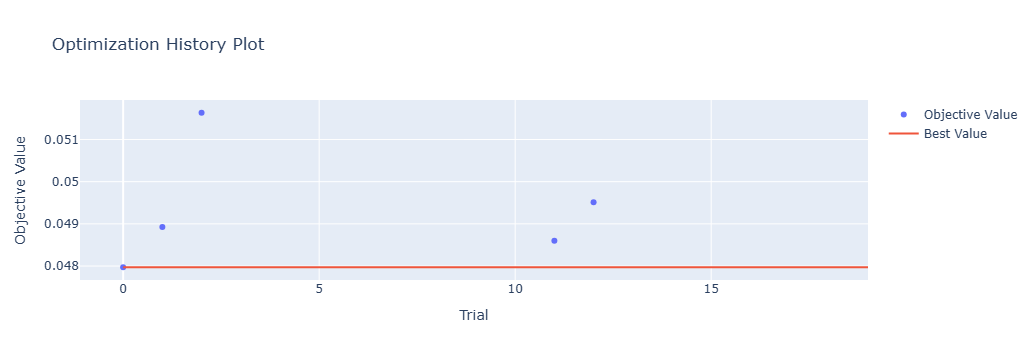

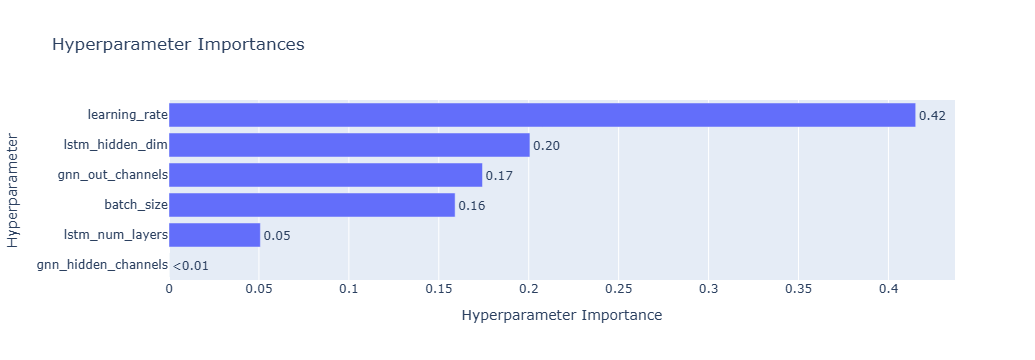

In [6]:
# Cell 6: Running the Optuna Study

# Set Optuna's own logging level so we can see its progress messages
# This should be done before creating the study if you want to see creation messages too.
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(optuna.logging.INFO) # INFO level shows trial creation and completion

# --- Configuration for this Optuna Run ---
N_TRIALS_OPTUNA = 20  # MODIFIED: Start with a manageable number of trials (e.g., 10-20)
                      # You can increase this later and re-run to continue the study.

# NUM_EPOCHS_OPTUNA is defined in Cell 1 (e.g., 15 epochs per trial)

# Pruning configuration
# n_startup_trials: Don't prune the first few trials, let them run fully.
# n_warmup_steps: Don't prune within the first few epochs of any trial.
# interval_steps: How often to check for pruning after warmup.
pruner_optuna = optuna.pruners.MedianPruner(
    n_startup_trials=3,  # Let the first 3 trials run without pruning
    n_warmup_steps=max(1, NUM_EPOCHS_OPTUNA // 4), # Warmup for ~25% of epochs (at least 1)
    interval_steps=1
)

# --- MODIFIED: Use a new, unique study name for this multi-year dataset ---
study_name_optuna = "stgnn_multiyear_study_v1" # Example: "stgnn_multiyear_study_v1"
storage_name_optuna = f"sqlite:///{study_name_optuna}.db" # Study results will be saved here

# Create the study
study = optuna.create_study(
    study_name=study_name_optuna,
    storage=storage_name_optuna,
    load_if_exists=True,  # If a DB with this name exists, Optuna will try to resume/add to it.
                          # For a truly fresh start with this name, delete the .db file first or set to False.
    direction="minimize",   # We want to minimize validation loss
    pruner=pruner_optuna
)

print(f"\n--- Starting/Resuming Optuna Study: '{study_name_optuna}' ---")
# Calculate how many new trials to run if resuming
completed_trials_count = len(study.trials)
new_trials_to_run = N_TRIALS_OPTUNA - completed_trials_count
if new_trials_to_run <= 0:
    print(f"Study already has {completed_trials_count} trials. No new trials requested (N_TRIALS_OPTUNA={N_TRIALS_OPTUNA}).")
    new_trials_to_run = 0 # Ensure it's not negative
else:
    print(f"Study currently has {completed_trials_count} trials. Will run {new_trials_to_run} new trials (target total: {N_TRIALS_OPTUNA}).")

print(f"Each new trial will run for up to {NUM_EPOCHS_OPTUNA} epochs (from Cell 1 config).")
print(f"Using device: {device}")

# Ensure data is loaded (global X_train_tensor should be populated by Cell 3)
if X_train_tensor is None:
    print("ERROR: X_train_tensor is None. Please ensure Cell 3 (Data Loading) has been run successfully before this cell.")
else:
    print(f"Training data shape (for reference): {X_train_tensor.shape}")

    if new_trials_to_run > 0:
        try:
            # `n_trials` in study.optimize is the number of *new* trials to run
            study.optimize(objective, n_trials=new_trials_to_run, timeout=None) # `objective` is defined in Cell 5
        except KeyboardInterrupt:
            print("\nOptuna study interrupted by user.")
        except Exception as e_optuna:
            print(f"\nAn error occurred during the Optuna study: {e_optuna}")
            import traceback
            traceback.print_exc()
    else:
        print("No new trials to run based on N_TRIALS_OPTUNA and existing trials in the study.")


print("\n--- Optuna Study Information ---")
print(f"Total number of trials in study '{study_name_optuna}': {len(study.trials)}")

if study.trials: # Check if there are any trials at all
    try:
        best_trial_optuna = study.best_trial
        print("\nBest trial found in study:")
        print(f"  Trial Number: {best_trial_optuna.number}")
        print(f"  Value (Min Validation Loss): {best_trial_optuna.value:.6f}")
        print("  Parameters: ")
        for key, value in best_trial_optuna.params.items():
            print(f"    {key}: {value}")

        # Save best hyperparameters
        # The filename will include the study name to keep it organized
        best_params_optuna_path = os.path.join(model_ready_data_dir, f'{study_name_optuna}_best_params.json')
        with open(best_params_optuna_path, 'w') as f_json:
            json.dump(best_trial_optuna.params, f_json, indent=4)
        print(f"\nBest hyperparameters from study '{study_name_optuna}' saved to: {best_params_optuna_path}")

        # Visualization (optional, requires plotly)
        # Ensure there are enough completed (non-pruned) trials for meaningful plots
        if len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]) > 1:
            print("\nGenerating Optuna visualization plots (requires plotly)...")
            try:
                if optuna.visualization.is_available():
                    fig_history = optuna.visualization.plot_optimization_history(study)
                    fig_history.show()

                    fig_importance = optuna.visualization.plot_param_importances(study)
                    fig_importance.show()

                    # Slice plot can be helpful but might be overwhelming with many params
                    # fig_slice = optuna.visualization.plot_slice(study)
                    # fig_slice.show()
                else:
                    print("Optuna visualization is not available. Consider installing plotly: pip install plotly")
            except (ImportError, ValueError, RuntimeError) as e_plot:
                print(f"Could not generate Optuna plots: {e_plot}")
                print("This can happen if plotly is not installed or if there are too few completed trials for some plots.")
        else:
            print("Not enough completed trials to generate all Optuna plots.")
    except ValueError:
        print("No trials completed successfully in the study (e.g., all pruned or study stopped early). Cannot determine best trial.")
    except Exception as e_best_trial:
        print(f"An error occurred retrieving or processing the best trial: {e_best_trial}")
else:
 
    int("No trials were run or found in the study.")


--- Preparing for Final Model Training ---
Loaded best hyperparameters from D:\.Study\projects\EnergyForecasting\data\model_ready\stgnn_multiyear_study_v1_best_params.json:
{
    "learning_rate": 0.000613049645560782,
    "batch_size": 32,
    "gnn_hidden_channels": 128,
    "gnn_out_channels": 48,
    "lstm_hidden_dim": 128,
    "lstm_num_layers": 2
}

Instantiating final model with best hyperparameters...
Final training using Batch Size: 32, LR: 0.00061

--- Starting Final Training (up to 120 epochs) ---
Epoch [001/120] | Train Loss: 0.149106 | Val Loss: 0.103904 | LR: 6.1e-04
  ----> Val loss improved to 0.103904. Model saved to D:\.Study\projects\EnergyForecasting\data\model_ready\stgnn_multiyear_study_v1_model_final_trained_multiyear.pth
Epoch [002/120] | Train Loss: 0.076255 | Val Loss: 0.070704 | LR: 6.1e-04
  ----> Val loss improved to 0.070704. Model saved to D:\.Study\projects\EnergyForecasting\data\model_ready\stgnn_multiyear_study_v1_model_final_trained_multiyear.pth
Epoch

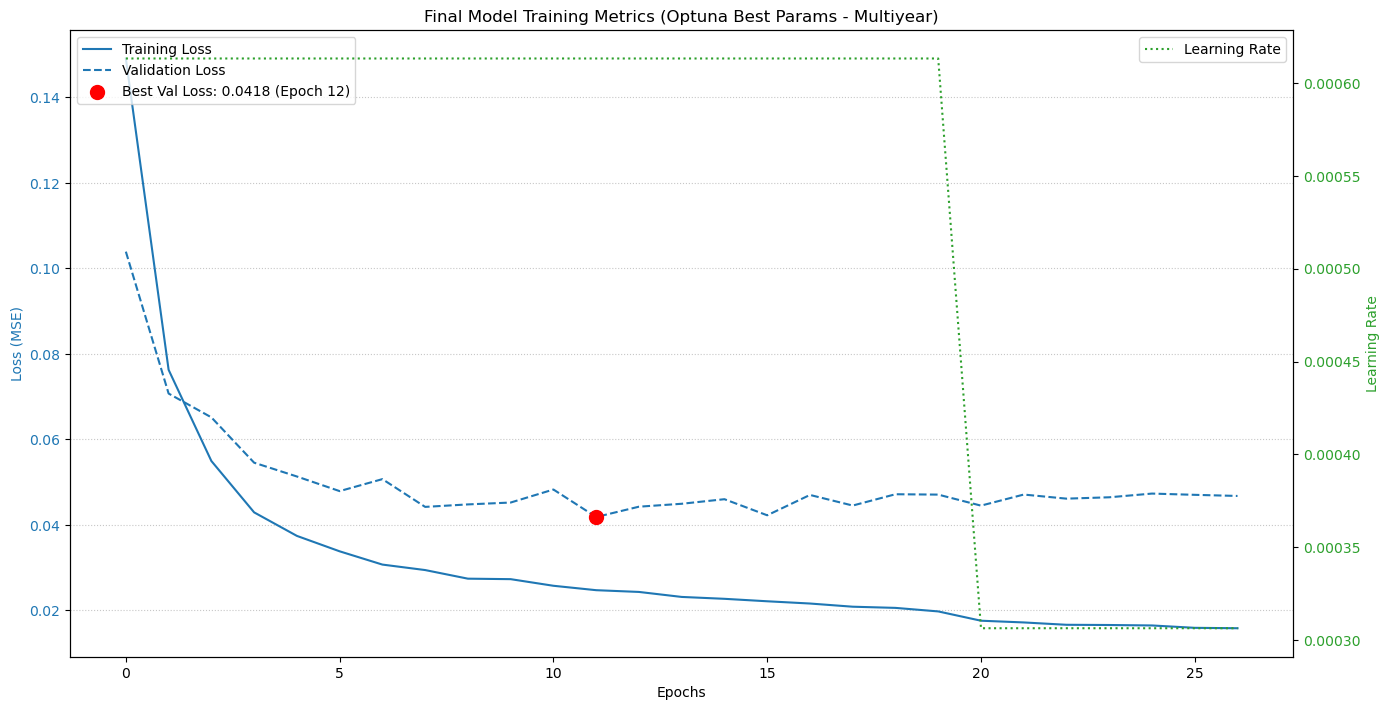

In [10]:
# Cell 7: Training the Final Model with Best Hyperparameters

print("\n--- Preparing for Final Model Training ---")

# --- USE NEW STUDY NAME FOR LOADING BEST PARAMS ---
final_study_name_for_params = "stgnn_multiyear_study_v1" # MUST MATCH Cell 6 study_name_optuna
final_best_params_path = os.path.join(model_ready_data_dir, f'{final_study_name_for_params}_best_params.json')

try:
    with open(final_best_params_path, 'r') as f_final:
        best_params_final = json.load(f_final)
    print(f"Loaded best hyperparameters from {final_best_params_path}:")
    print(json.dumps(best_params_final, indent=4))

    # ... (Assign best params to final_... variables, same as before) ...
    final_lr = best_params_final.get("learning_rate", 0.001)
    # ... (all other final_... param assignments)
    final_batch_size = best_params_final.get("batch_size", 32)
    final_gnn_h = best_params_final.get("gnn_hidden_channels", 64)
    final_gnn_o = best_params_final.get("gnn_out_channels", 32)
    final_lstm_h = best_params_final.get("lstm_hidden_dim", 128)
    final_lstm_l = best_params_final.get("lstm_num_layers", 2)
    final_dropout = FIXED_DROPOUT_RATE # Using fixed from Cell 1 for now

    print("\nInstantiating final model with best hyperparameters...")
    final_model_instance = STGNN_Model(
        # ... (pass all necessary model_... args, including final_... hyperparams) ...
        model_num_all_features_in_df=num_all_features_in_df, model_num_nodes=num_nodes,
        model_num_features_per_node_slice_for_gnn=num_features_per_node_slice_FOR_GNN,
        gnn_hidden_channels=final_gnn_h, gnn_out_channels=final_gnn_o,
        lstm_hidden_dim=final_lstm_h, num_lstm_layers=final_lstm_l,
        model_all_zones_list=zone_identifiers, model_common_time_features_list=common_time_features_gnn_for_init,
        dropout_rate=final_dropout, model_pred_horizon=PREDICTION_HORIZON
    ).to(device)

    # ... (DataLoaders for final training, same as before) ...
    final_train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
    final_val_dataset = TimeSeriesDataset(X_val_tensor, y_val_tensor)
    final_train_loader = DataLoader(final_train_dataset, batch_size=final_batch_size, shuffle=True, drop_last=True)
    final_val_loader = DataLoader(final_val_dataset, batch_size=final_batch_size, shuffle=False, drop_last=True)
    print(f"Final training using Batch Size: {final_batch_size}, LR: {final_lr:.5f}")


    NUM_EPOCHS_FINAL_TRAIN = 120  # MODIFIED: Can be adjusted based on dataset size and Optuna results (e.g., 50-150)
    # ... (Other final training loop parameters: FINAL_WEIGHT_DECAY etc., same as before) ...
    FINAL_WEIGHT_DECAY = 1e-5
    FINAL_GRADIENT_CLIP_VALUE = 1.0
    FINAL_LR_SCHEDULER_PATIENCE = 7 # Adjusted from 10
    FINAL_LR_SCHEDULER_FACTOR = 0.5
    FINAL_LR_SCHEDULER_MIN_LR = 1e-6
    FINAL_EARLY_STOPPING_PATIENCE = 15 # Adjusted from 20

    # --- NEW FINAL MODEL SAVE PATH NAME ---
    final_model_save_path = os.path.join(model_ready_data_dir, f'{final_study_name_for_params}_model_final_trained_multiyear.pth')

    criterion_final = nn.MSELoss()
    optimizer_final = optim.Adam(final_model_instance.parameters(), lr=final_lr, weight_decay=FINAL_WEIGHT_DECAY)
    scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_final, mode='min', factor=FINAL_LR_SCHEDULER_FACTOR,
        patience=FINAL_LR_SCHEDULER_PATIENCE, min_lr=FINAL_LR_SCHEDULER_MIN_LR
    )

    print(f"\n--- Starting Final Training (up to {NUM_EPOCHS_FINAL_TRAIN} epochs) ---")
    # ... (The rest of your training loop from the previous Cell 7, using final_... variables) ...
    # ... (Ensure it uses final_model_instance, final_train_loader, final_val_loader, final_model_save_path etc.)
    train_losses_final, val_losses_final, learning_rates_final = [], [], []
    best_val_loss_final_run = float('inf')
    epochs_no_improve_final = 0

    if not os.path.exists(os.path.dirname(final_model_save_path)):
        os.makedirs(os.path.dirname(final_model_save_path))

    for epoch_final in range(NUM_EPOCHS_FINAL_TRAIN):
        final_model_instance.train()
        epoch_tr_loss = 0.0
        current_lr_val = optimizer_final.param_groups[0]['lr']
        learning_rates_final.append(current_lr_val)

        for x_b, y_b in final_train_loader:
            x_b, y_b = x_b.to(device), y_b.to(device)
            optimizer_final.zero_grad()
            preds = final_model_instance(x_b, edge_index)
            loss_tr = criterion_final(preds, y_b)
            loss_tr.backward()
            if FINAL_GRADIENT_CLIP_VALUE:
                torch.nn.utils.clip_grad_norm_(final_model_instance.parameters(), FINAL_GRADIENT_CLIP_VALUE)
            optimizer_final.step()
            epoch_tr_loss += loss_tr.item()
        avg_tr_loss = epoch_tr_loss / len(final_train_loader)
        train_losses_final.append(avg_tr_loss)

        final_model_instance.eval()
        epoch_v_loss = 0.0
        with torch.no_grad():
            for x_v, y_v in final_val_loader:
                x_v, y_v = x_v.to(device), y_v.to(device)
                preds_v = final_model_instance(x_v, edge_index)
                loss_v = criterion_final(preds_v, y_v)
                epoch_v_loss += loss_v.item()
        avg_v_loss = epoch_v_loss / len(final_val_loader)
        val_losses_final.append(avg_v_loss)
        scheduler_final.step(avg_v_loss)

        lr_change_msg = f" (LR Reduced to {optimizer_final.param_groups[0]['lr']:.1e})" if optimizer_final.param_groups[0]['lr'] < current_lr_val else ""
        print(f"Epoch [{epoch_final+1:03d}/{NUM_EPOCHS_FINAL_TRAIN:03d}] | Train Loss: {avg_tr_loss:.6f} | Val Loss: {avg_v_loss:.6f} | LR: {current_lr_val:.1e}{lr_change_msg}")

        if avg_v_loss < best_val_loss_final_run:
            best_val_loss_final_run = avg_v_loss
            torch.save(final_model_instance.state_dict(), final_model_save_path)
            print(f"  ----> Val loss improved to {best_val_loss_final_run:.6f}. Model saved to {final_model_save_path}")
            epochs_no_improve_final = 0
        else:
            epochs_no_improve_final += 1
            if epochs_no_improve_final >= FINAL_EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered at epoch {epoch_final+1} for final training.")
                break
    
    print("\n--- Final Training Complete ---") # ... Plotting ...

    # Plotting (same logic, just ensure variables are correct)
    if train_losses_final and val_losses_final: # Check if lists are populated
        fig_final, ax1_final = plt.subplots(figsize=(14, 7))
        color_loss = 'tab:blue'
        ax1_final.set_xlabel('Epochs')
        ax1_final.set_ylabel('Loss (MSE)', color=color_loss)
        ax1_final.plot(train_losses_final, color=color_loss, linestyle='-', label='Training Loss')
        ax1_final.plot(val_losses_final, color=color_loss, linestyle='--', label='Validation Loss')
        ax1_final.tick_params(axis='y', labelcolor=color_loss)
        if val_losses_final:
            best_val_idx_final = np.argmin(val_losses_final)
            ax1_final.scatter(best_val_idx_final, val_losses_final[best_val_idx_final], marker='o', color='red', s=100, zorder=5,
                              label=f'Best Val Loss: {val_losses_final[best_val_idx_final]:.4f} (Epoch {best_val_idx_final+1})')
        ax1_final.legend(loc='upper left')
        ax1_final.grid(True, axis='y', linestyle=':', alpha=0.7)
        if learning_rates_final:
            ax2_final = ax1_final.twinx()
            color_lr = 'tab:green'
            ax2_final.set_ylabel('Learning Rate', color=color_lr)
            ax2_final.plot(learning_rates_final, color=color_lr, linestyle=':', label='Learning Rate')
            ax2_final.tick_params(axis='y', labelcolor=color_lr)
            ax2_final.legend(loc='upper right')
        fig_final.tight_layout()
        plt.title('Final Model Training Metrics (Optuna Best Params - Multiyear)')
        plt.show()
    else:
        print("No training/validation losses recorded for final model to plot.")


except FileNotFoundError:
    print(f"ERROR: Best hyperparameters file not found at {final_best_params_path}. "
          "Please ensure the Optuna study (Cell 6) has run successfully and saved the parameters, "
          "and the `final_study_name_for_params` variable matches the one used in Cell 6.")
except Exception as e_final:
    print(f"An error occurred during final model training: {e_final}")
    import traceback
    
    traceback.print_exc()


--- Preparing for Test Set Evaluation ---
Scaler loaded from D:\.Study\projects\EnergyForecasting\data\model_ready\feature_scaler_multiyear.joblib
Using best_params_final already in memory.
Attempting to load test data from: D:\.Study\projects\EnergyForecasting\data\model_ready\test_scaled_multiyear.csv
Loaded test_scaled_multiyear.csv for evaluation. Shape: (4458, 94)
Test data sequences and DataLoader created. X_test_tensor shape: torch.Size([4434, 24, 94])
Model for evaluation loaded from D:\.Study\projects\EnergyForecasting\data\model_ready\stgnn_multiyear_study_v1_model_final_trained_multiyear.pth and set to eval mode.
Making predictions on the test set...
Predictions complete.
Inverse transforming predictions and true values...
Inverse transformation complete.

Checking value distribution for zone DOM in ORIGINAL SCALE test data (test_true_df_orig)...
count     4434.000000
mean     14801.637045
std       2342.233502
min      10802.590016
25%      13070.861249
50%      14344.3195

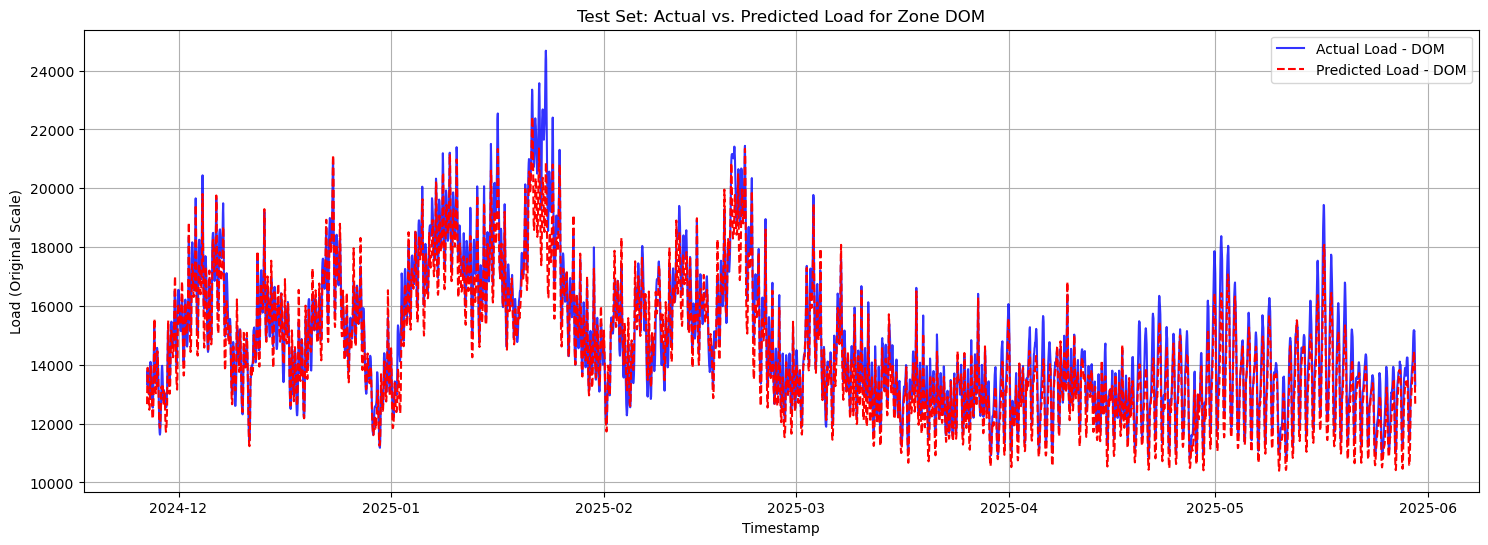

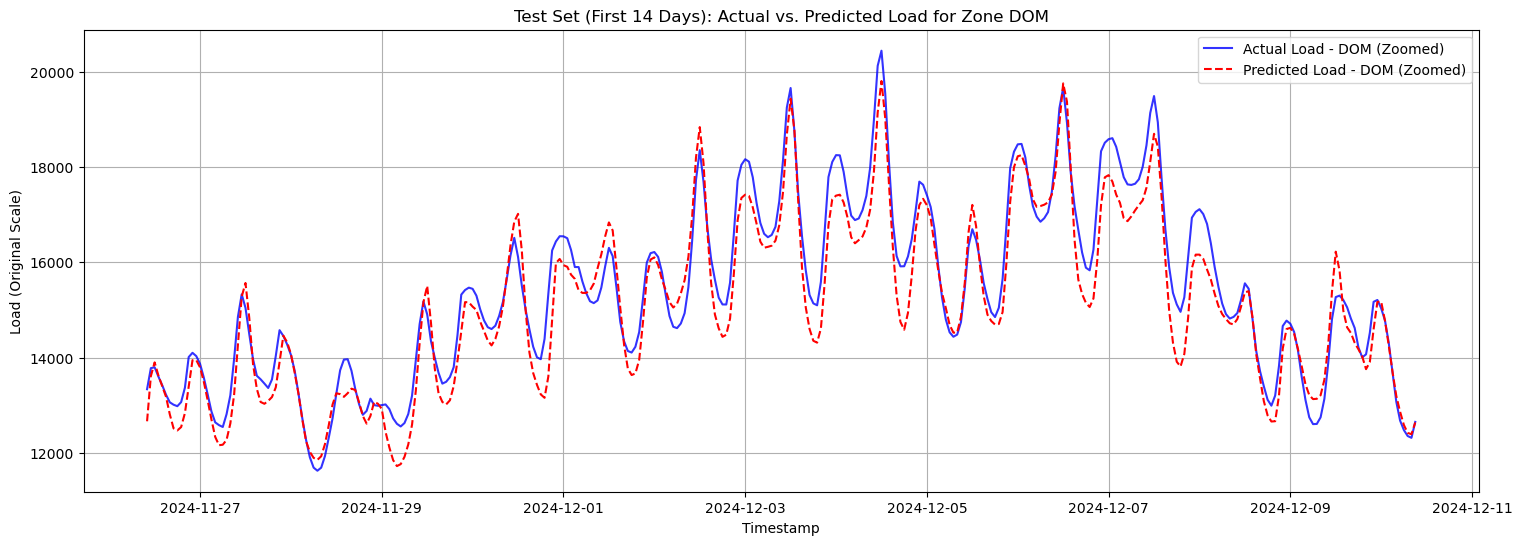

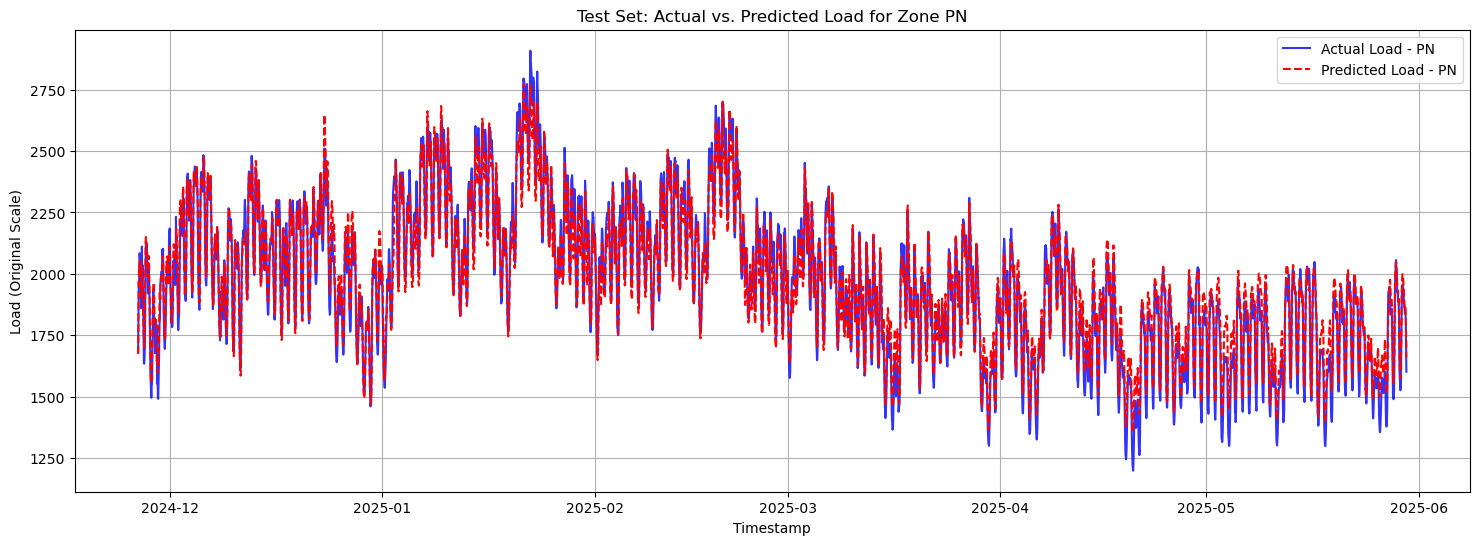

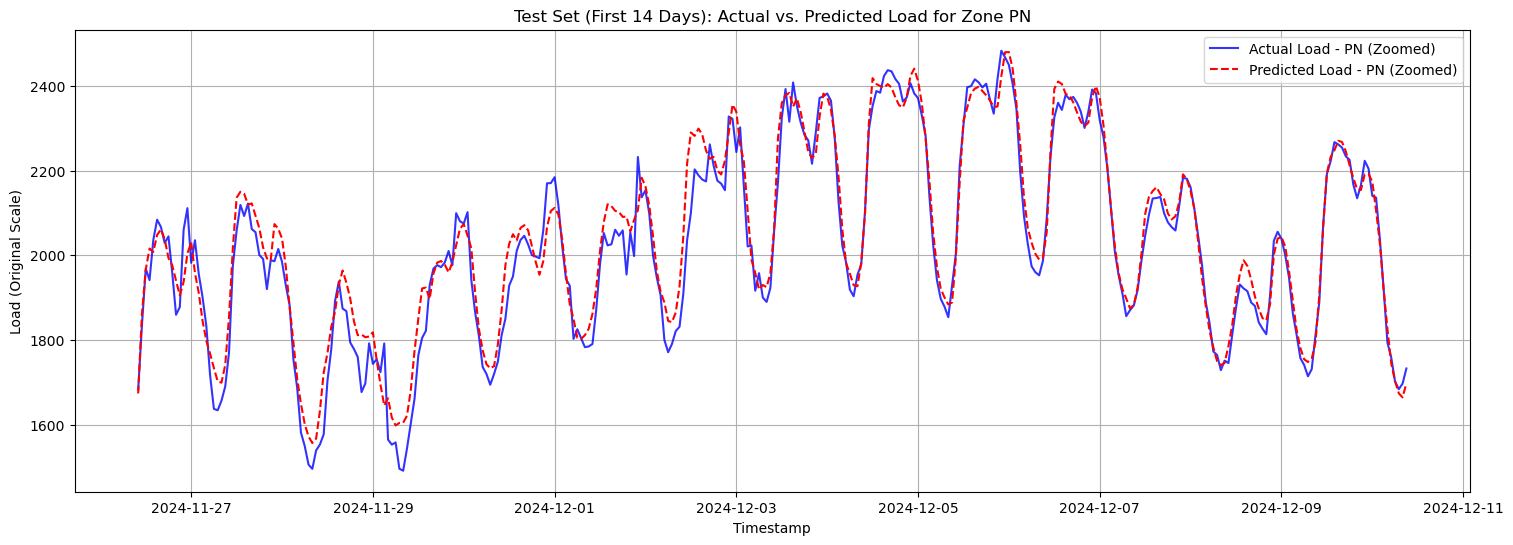

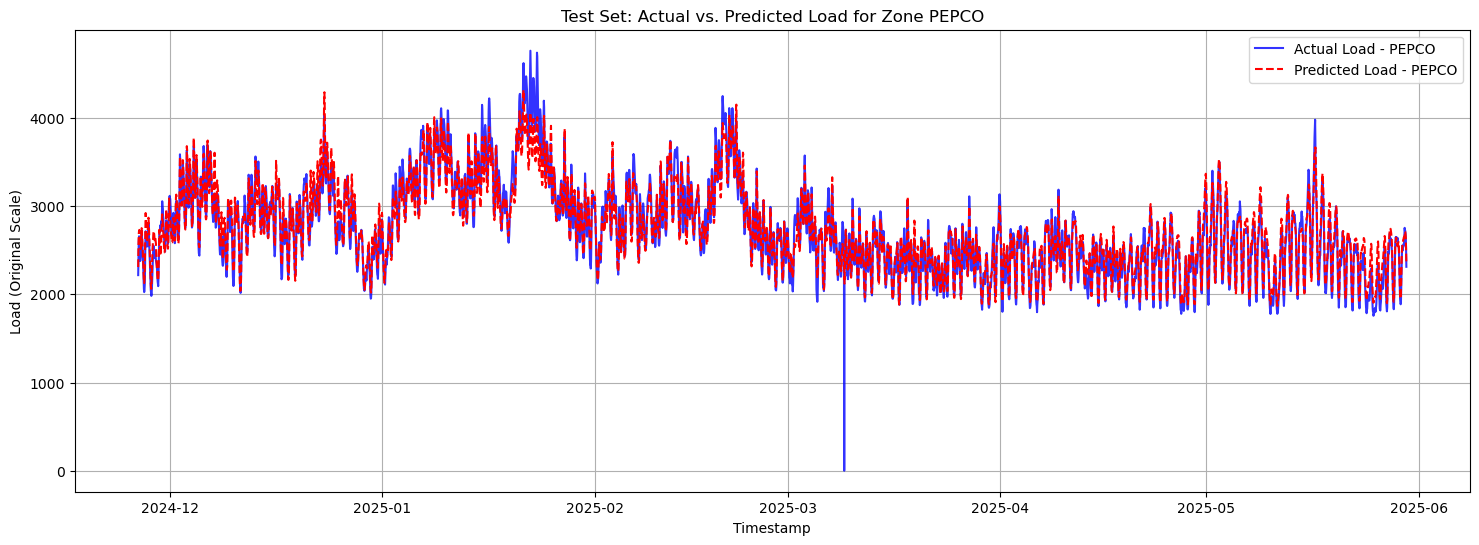

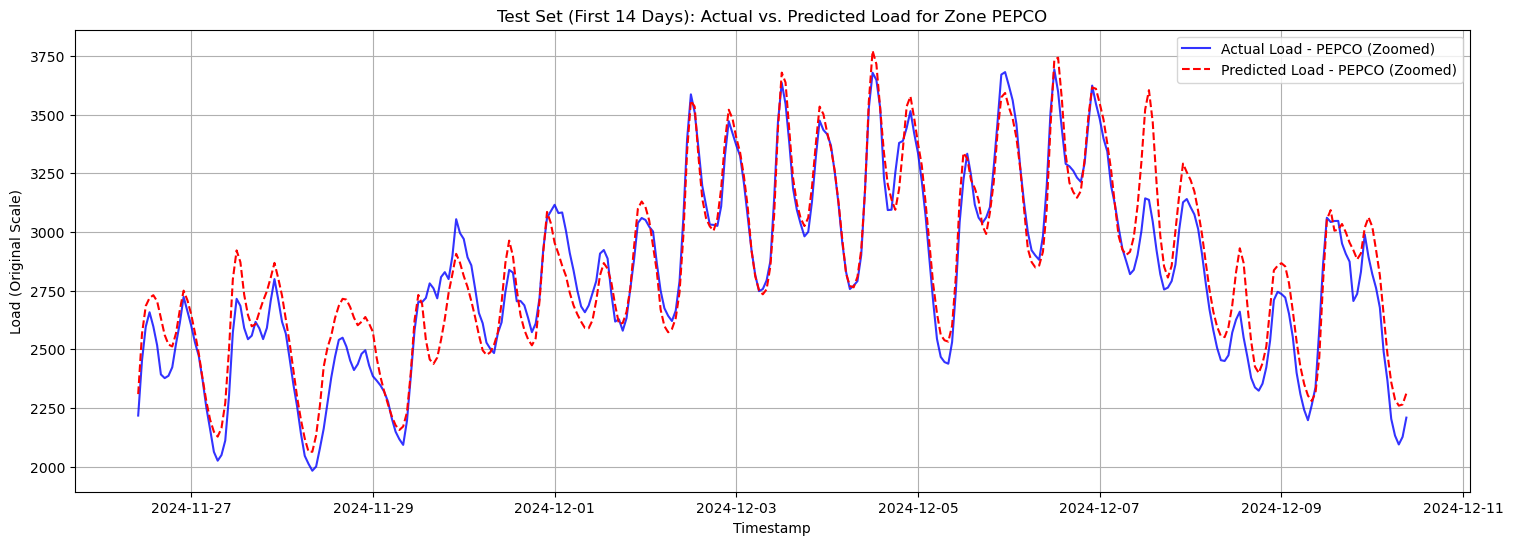

In [29]:
# Cell 8: Test Set Evaluation

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib # For loading the scaler
import json   # For loading best_params_final if not already loaded
import os     # Make sure os is imported

print("\n--- Preparing for Test Set Evaluation ---")

# --- Ensure necessary global variables are loaded/defined ---
required_globals = [
    'device', 'zone_identifiers', 'target_column_template', 'INPUT_SEQ_LEN', 'PREDICTION_HORIZON',
    'model_ready_data_dir', 'edge_index', 'create_sequences', 'TimeSeriesDataset', 'STGNN_Model',
    'num_all_features_in_df', 'num_nodes', 'num_features_per_node_slice_FOR_GNN',
    'common_time_features_gnn_for_init', 'FIXED_DROPOUT_RATE', 'scaler_path_multiyear',
    'train_scaled_df' # Needed for column structure reference for scaler
]
for var_name in required_globals:
    if var_name not in globals():
        print(f"ERROR: Global variable '{var_name}' is missing. Please ensure prerequisite cells (1, 2, 3, 4) are run.")
        raise NameError(f"Missing global variable: {var_name}")

# --- Load Scaler ---
try:
    scaler = joblib.load(scaler_path_multiyear)
    print(f"Scaler loaded from {scaler_path_multiyear}")
except FileNotFoundError:
    print(f"ERROR: Scaler file not found at {scaler_path_multiyear}")
    raise

# --- Load Best Hyperparameters ---
if 'best_params_final' not in globals():
    print("best_params_final not in globals, attempting to load...")
    final_study_name_for_params_test = "stgnn_multiyear_study_v1"
    final_best_params_path_test = os.path.join(model_ready_data_dir, f'{final_study_name_for_params_test}_best_params.json')
    try:
        with open(final_best_params_path_test, 'r') as f_test_params:
            best_params_final = json.load(f_test_params)
        print(f"Loaded best hyperparameters from {final_best_params_path_test}")
    except FileNotFoundError:
        print(f"ERROR: Best hyperparameters file not found at {final_best_params_path_test}. Run Cell 6 & 7 first.")
        raise
else:
    print("Using best_params_final already in memory.")

# --- Load Test Data ---
test_scaled_df = None
try:
    test_data_filename = 'test_scaled_multiyear.csv'
    test_data_full_path = os.path.join(model_ready_data_dir, test_data_filename)
    print(f"Attempting to load test data from: {test_data_full_path}")
    test_scaled_df = pd.read_csv(test_data_full_path, index_col=0, parse_dates=True)
    print(f"Loaded {test_data_filename} for evaluation. Shape: {test_scaled_df.shape}")
    
    # DEBUG: Print columns of the loaded test_scaled_df
    # print("\nColumns in loaded test_scaled_df (multiyear):")
    # print(list(test_scaled_df.columns))
    # print("-" * 30 + "\n")

    X_test_seq, y_test_seq = create_sequences(test_scaled_df, INPUT_SEQ_LEN, PREDICTION_HORIZON, target_column_template, zone_identifiers)
    X_test_tensor = torch.from_numpy(X_test_seq).float()
    y_test_tensor = torch.from_numpy(y_test_seq).float()

    test_dataset_eval = TimeSeriesDataset(X_test_tensor, y_test_tensor)
    eval_batch_size = best_params_final.get("batch_size", 32)
    test_loader_eval = DataLoader(test_dataset_eval, batch_size=eval_batch_size, shuffle=False)
    print(f"Test data sequences and DataLoader created. X_test_tensor shape: {X_test_tensor.shape}")
except FileNotFoundError:
    print(f"ERROR: {test_data_filename} not found at {test_data_full_path}")
    raise
except KeyError as e_key:
    print(f"KeyError during test data sequence creation: {e_key}")
    print("This often means a mismatch between `zone_identifiers` in Cell 1 and column names in the loaded CSV.")
    print(f"Current zone_identifiers: {zone_identifiers}")
    print("Please verify against the actual column names in your CSV (you can print test_scaled_df.columns).")
    raise
except Exception as e:
    print(f"Error during test data preparation: {e}")
    raise

# --- Load Best Trained Model ---
final_model_save_name_test = "stgnn_multiyear_study_v1_model_final_trained_multiyear.pth"
final_model_path_test = os.path.join(model_ready_data_dir, final_model_save_name_test)

model_for_eval = STGNN_Model(
    model_num_all_features_in_df=num_all_features_in_df, model_num_nodes=num_nodes,
    model_num_features_per_node_slice_for_gnn=num_features_per_node_slice_FOR_GNN,
    gnn_hidden_channels=best_params_final.get("gnn_hidden_channels"),
    gnn_out_channels=best_params_final.get("gnn_out_channels"),
    lstm_hidden_dim=best_params_final.get("lstm_hidden_dim"),
    num_lstm_layers=best_params_final.get("lstm_num_layers"),
    model_all_zones_list=zone_identifiers,
    model_common_time_features_list=common_time_features_gnn_for_init,
    dropout_rate=0.0,  # Set dropout to 0.0 for deterministic evaluation
    model_pred_horizon=PREDICTION_HORIZON
).to(device)

try:
    model_for_eval.load_state_dict(torch.load(final_model_path_test, map_location=device))
    model_for_eval.eval()
    print(f"Model for evaluation loaded from {final_model_path_test} and set to eval mode.")
except FileNotFoundError:
    print(f"ERROR: Trained model file not found at {final_model_path_test}. Ensure Cell 7 ran successfully.")
    raise

# --- Get Predictions on Test Set ---
all_test_preds_scaled_list = []
all_test_true_scaled_list = []
print("Making predictions on the test set...")
with torch.no_grad():
    for x_batch_test, y_batch_test in test_loader_eval:
        x_batch_test = x_batch_test.to(device)
        predictions_test_scaled = model_for_eval(x_batch_test, edge_index)
        all_test_preds_scaled_list.append(predictions_test_scaled.cpu().numpy())
        all_test_true_scaled_list.append(y_batch_test.cpu().numpy())
all_test_preds_scaled = np.concatenate(all_test_preds_scaled_list, axis=0)
all_test_true_scaled = np.concatenate(all_test_true_scaled_list, axis=0)
print("Predictions complete.")

# --- Inverse Transform Predictions and True Values ---
print("Inverse transforming predictions and true values...")
target_load_cols_test = [target_column_template.replace('{ZONE}', zone) for zone in zone_identifiers]
num_test_samples = len(all_test_true_scaled)
test_target_start_idx = INPUT_SEQ_LEN + PREDICTION_HORIZON - 1
test_target_timestamps = test_scaled_df.index[test_target_start_idx : test_target_start_idx + num_test_samples]
df_structure_cols = train_scaled_df.columns

test_preds_full_scaled = pd.DataFrame(0.0, index=test_target_timestamps, columns=df_structure_cols)
test_true_full_scaled = pd.DataFrame(0.0, index=test_target_timestamps, columns=df_structure_cols)

for col_idx, col_name in enumerate(target_load_cols_test):
    if col_name in test_preds_full_scaled.columns:
        test_preds_full_scaled[col_name] = all_test_preds_scaled[:, col_idx]
        test_true_full_scaled[col_name] = all_test_true_scaled[:, col_idx]
    else:
        print(f"Warning: Target column '{col_name}' not found in scaler's structure. Check `train_scaled_df.columns` vs `target_load_cols_test`.")

for col_name in df_structure_cols:
    if col_name not in target_load_cols_test:
        if col_name in test_scaled_df.columns:
            try:
                values_to_fill = test_scaled_df.loc[test_target_timestamps, col_name].values
                if len(values_to_fill) == len(test_target_timestamps):
                    test_preds_full_scaled[col_name] = values_to_fill
                    test_true_full_scaled[col_name] = values_to_fill
                else: # Should not happen if test_target_timestamps is correct
                    print(f"Warning: Length mismatch for non-target column {col_name} fill. Using 0.")
            except KeyError:
                 print(f"Warning: Timestamp mismatch or column {col_name} not fully in test_scaled_df for filling. Using 0.")

test_preds_original_array = scaler.inverse_transform(test_preds_full_scaled)
test_true_original_array = scaler.inverse_transform(test_true_full_scaled)
test_preds_df_orig = pd.DataFrame(test_preds_original_array, columns=df_structure_cols, index=test_target_timestamps)[target_load_cols_test]
test_true_df_orig = pd.DataFrame(test_true_original_array, columns=df_structure_cols, index=test_target_timestamps)[target_load_cols_test]
print("Inverse transformation complete.")

# --- Data Distribution Check (Moved before metrics) ---
for zone_name_dist in zone_identifiers:
    target_col_dist = target_column_template.replace('{ZONE}', zone_name_dist)
    if target_col_dist in test_true_df_orig.columns:
        print(f"\nChecking value distribution for zone {zone_name_dist} in ORIGINAL SCALE test data (test_true_df_orig)...")
        print(test_true_df_orig[target_col_dist].describe())
        print(f"Value counts (binned) for {zone_name_dist}:")
        print(test_true_df_orig[target_col_dist].value_counts(bins=5, dropna=False, normalize=True) * 100) # Percentages
        print(f"  Count of values <= 1: {(test_true_df_orig[target_col_dist] <= 1).sum()}")
        print(f"  Count of values <= 0: {(test_true_df_orig[target_col_dist] <= 0).sum()}")
    else:
        print(f"Warning: Column {target_col_dist} not found in test_true_df_orig for distribution check.")


print("\nTest Set Evaluation (Original Scale):")
overall_metrics = {}
for zone_idx, zone_name in enumerate(zone_identifiers):
    target_col = target_load_cols_test[zone_idx]
    if target_col not in test_true_df_orig.columns:
        print(f"Skipping metrics for zone {zone_name} as target column '{target_col}' not found in results.")
        continue
        
    true_vals = test_true_df_orig[target_col]
    pred_vals = test_preds_df_orig[target_col]

    mse = mean_squared_error(true_vals, pred_vals)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_vals, pred_vals)
    
    # Refined MAPE Calculation
    mape_epsilon = 1.0 # A small constant to avoid division by zero or near-zero issues
    true_vals_for_mape = true_vals.copy()
    # Handle cases where true_vals_for_mape could be zero or negative after adding epsilon for stability
    denominator_mape = true_vals_for_mape.copy()
    # Option 1: Add epsilon (if values are strictly positive, this is simpler)
    # denominator_mape = true_vals_for_mape + mape_epsilon
    # Option 2: Replace problematic values with NaN (more robust if negatives or true zeros exist)
    problematic_mask = (np.abs(true_vals_for_mape) < mape_epsilon) # Values too close to zero
    denominator_mape[problematic_mask] = np.nan
    
    if denominator_mape.isnull().all(): # If all values became NaN
        mape = np.nan # Or some other indicator that MAPE is not calculable
        print(f"Warning: All denominators for MAPE in zone {zone_name} became NaN. MAPE set to NaN.")
    else:
        mape_abs_errors = np.abs((true_vals - pred_vals) / denominator_mape)
        mape = np.nanmean(mape_abs_errors) * 100
    
    r2 = r2_score(true_vals, pred_vals)

    print(f"\n--- Metrics for Zone: {zone_name} ---")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  MAPE (adjusted, problematic values near zero handled): {mape:.2f}%")
    print(f"  R2:   {r2:.3f}")
    overall_metrics[zone_name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

avg_rmse = np.nanmean([m.get('RMSE', np.nan) for m in overall_metrics.values()])
avg_mae = np.nanmean([m.get('MAE', np.nan) for m in overall_metrics.values()])
avg_mape = np.nanmean([m.get('MAPE', np.nan) for m in overall_metrics.values()])
print(f"\n--- Average Metrics Across Zones (NaNs ignored) ---")
print(f"  Avg RMSE: {avg_rmse:.2f}")
print(f"  Avg MAE:  {avg_mae:.2f}")
print(f"  Avg MAPE: {avg_mape:.2f}%")

# --- Plot Predictions vs. Actuals for Test Set ---
if zone_identifiers and not test_true_df_orig.empty and not test_preds_df_orig.empty:
    num_zones_to_plot = min(len(zone_identifiers), 3)
    for i in range(num_zones_to_plot):
        zone_to_plot_test = zone_identifiers[i]
        target_col_plot_test = target_column_template.replace('{ZONE}', zone_to_plot_test)
        if target_col_plot_test not in test_true_df_orig.columns:
            print(f"Skipping plot for zone {zone_to_plot_test}, column '{target_col_plot_test}' not found.")
            continue
            
        plt.figure(figsize=(18, 6))
        plt.plot(test_true_df_orig.index, test_true_df_orig[target_col_plot_test], label=f'Actual Load - {zone_to_plot_test}', color='blue', alpha=0.8)
        plt.plot(test_preds_df_orig.index, test_preds_df_orig[target_col_plot_test], label=f'Predicted Load - {zone_to_plot_test}', color='red', linestyle='--')
        plt.title(f'Test Set: Actual vs. Predicted Load for Zone {zone_to_plot_test}')
        plt.xlabel('Timestamp'); plt.ylabel('Load (Original Scale)'); plt.legend(); plt.grid(True)
        plt.show()

        plot_hours = min(len(test_true_df_orig), 24*7*2) # Plot first two weeks if available
        if plot_hours > 0:
            short_period_index = test_true_df_orig.index[:plot_hours]
            plt.figure(figsize=(18, 6))
            plt.plot(short_period_index, test_true_df_orig.loc[short_period_index, target_col_plot_test], label=f'Actual Load - {zone_to_plot_test} (Zoomed)', color='blue', alpha=0.8)
            plt.plot(short_period_index, test_preds_df_orig.loc[short_period_index, target_col_plot_test], label=f'Predicted Load - {zone_to_plot_test} (Zoomed)', color='red', linestyle='--')
            plt.title(f'Test Set (First {plot_hours//24} Days): Actual vs. Predicted Load for Zone {zone_to_plot_test}')
            plt.xlabel('Timestamp'); plt.ylabel('Load (Original Scale)'); plt.legend(); plt.grid(True)
            plt.show()
else:
    print("Skipping test set plots due to missing data or identifiers.")

In [30]:
# Cell 9: Sample Prediction and "Accuracy" Check

print("\n--- Sample Prediction Demonstration ---")

# Ensure necessary variables are available from previous cells (especially Cell 8)
required_for_sample = [
    'model_for_eval', 'test_scaled_df', 'scaler', 'X_test_seq', 'y_test_seq', 
    'edge_index', 'zone_identifiers', 'target_column_template', 
    'INPUT_SEQ_LEN', 'PREDICTION_HORIZON', 'train_scaled_df' # For df_structure_cols
]
missing_vars_sample = [var for var in required_for_sample if var not in globals()]
if missing_vars_sample:
    print(f"ERROR: Required variables for sample prediction are missing: {missing_vars_sample}")
    print("Please ensure Cell 8 (Test Set Evaluation) has run successfully, or necessary objects are loaded/re-run.")
else:
    sample_idx = 0 # Pick a sample (e.g., 0, 10, 100)
    if sample_idx < len(X_test_seq):
        single_input_sequence_scaled_np = X_test_seq[sample_idx]
        actual_target_scaled_np = y_test_seq[sample_idx] # This is an array of targets for all zones

        single_input_tensor_scaled = torch.from_numpy(single_input_sequence_scaled_np).float().unsqueeze(0).to(device)

        model_for_eval.eval()
        with torch.no_grad():
            predicted_target_scaled_tensor = model_for_eval(single_input_tensor_scaled, edge_index)
        predicted_target_scaled_np = predicted_target_scaled_tensor.cpu().numpy().squeeze(0)

        # Inverse Transform for this single sample
        target_timestamp_sample = test_scaled_df.index[INPUT_SEQ_LEN + PREDICTION_HORIZON - 1 + sample_idx]
        df_structure_cols_sample = train_scaled_df.columns # Use train_scaled_df for scaler structure
        
        target_load_cols_sample = [target_column_template.replace('{ZONE}', zone) for zone in zone_identifiers]

        # Create single-row DataFrames with full scaler structure
        pred_row_full_scaled = pd.DataFrame(0.0, index=[target_timestamp_sample], columns=df_structure_cols_sample)
        true_row_full_scaled = pd.DataFrame(0.0, index=[target_timestamp_sample], columns=df_structure_cols_sample)

        for col_idx, col_name in enumerate(target_load_cols_sample):
            if col_name in pred_row_full_scaled.columns:
                pred_row_full_scaled.loc[target_timestamp_sample, col_name] = predicted_target_scaled_np[col_idx]
                true_row_full_scaled.loc[target_timestamp_sample, col_name] = actual_target_scaled_np[col_idx]
            else:
                print(f"Warning (Sample Pred): Target col '{col_name}' not in scaler structure.")

        # Fill non-target columns with actual (scaled) values from test_scaled_df for that timestamp
        for col_name in df_structure_cols_sample:
            if col_name not in target_load_cols_sample:
                if col_name in test_scaled_df.columns:
                    try:
                        val_to_fill = test_scaled_df.loc[target_timestamp_sample, col_name]
                        pred_row_full_scaled.loc[target_timestamp_sample, col_name] = val_to_fill
                        true_row_full_scaled.loc[target_timestamp_sample, col_name] = val_to_fill
                    except KeyError: # Timestamp might not exist if test_scaled_df is shorter than expected by sample_idx logic
                        print(f"Warning (Sample Pred): Timestamp {target_timestamp_sample} or col {col_name} not in test_scaled_df for filling.")
                # else: # Already 0.0

        # Perform inverse transform
        pred_row_orig_array = scaler.inverse_transform(pred_row_full_scaled)
        true_row_orig_array = scaler.inverse_transform(true_row_full_scaled)

        # Extract only the target columns after inverse transforming
        # Get integer positions of target columns in df_structure_cols_sample
        target_col_indices = [df_structure_cols_sample.get_loc(tc) for tc in target_load_cols_sample if tc in df_structure_cols_sample]
        
        pred_target_orig_np = pred_row_orig_array[0, target_col_indices]
        actual_target_orig_np = true_row_orig_array[0, target_col_indices]
        
        # Ensure we map back to correct zones if target_col_indices didn't include all
        valid_target_load_cols_sample = [tc for tc in target_load_cols_sample if tc in df_structure_cols_sample]


        print(f"\nSample Prediction for Timestamp: {target_timestamp_sample}")
        print("----------------------------------------------------------------------")
        print(f"{'Zone':<7} | {'Actual Load':<15} | {'Predicted Load':<15} | {'Abs Error':<12} | {'% Error':<10}")
        print("----------------------------------------------------------------------")
        
        for i, zone_name_sample in enumerate(zone_identifiers):
            # Find the original index of this zone's target column in df_structure_cols_sample
            # This matches how pred_target_orig_np and actual_target_orig_np were constructed
            current_target_col = target_column_template.replace('{ZONE}', zone_name_sample)
            if current_target_col in valid_target_load_cols_sample:
                # Find index of current_target_col within valid_target_load_cols_sample to map to *_orig_np arrays
                try:
                    idx_in_orig_arrays = valid_target_load_cols_sample.index(current_target_col)
                    actual = actual_target_orig_np[idx_in_orig_arrays]
                    pred = pred_target_orig_np[idx_in_orig_arrays]
                    abs_error = abs(actual - pred)
                    
                    percent_error_denom = actual
                    if abs(actual) < 1.0: # Handle near-zero actuals for % error
                        percent_error_denom = 1.0 if actual >= 0 else -1.0 # Avoid division by zero, keep sign for context if desired
                    
                    percent_error = (abs_error / percent_error_denom) * 100 if percent_error_denom != 0 else float('inf')
                    
                    print(f"{zone_name_sample:<7} | {actual:<15.2f} | {pred:<15.2f} | {abs_error:<12.2f} | {percent_error:<9.2f}%")
                except ValueError:
                    print(f"{zone_name_sample:<7} | {'N/A (col missing)':<15} | {'N/A':<15} | {'N/A':<12} | {'N/A':<10}")
            else:
                print(f"{zone_name_sample:<7} | {'N/A (col missing)':<15} | {'N/A':<15} | {'N/A':<12} | {'N/A':<10}")

        print("----------------------------------------------------------------------")

    else:
        print(f"Sample index {sample_idx} is out of bounds for X_test_seq (length {len(X_test_seq)}).")


--- Sample Prediction Demonstration ---

Sample Prediction for Timestamp: 2024-11-26 10:00:00+00:00
----------------------------------------------------------------------
Zone    | Actual Load     | Predicted Load  | Abs Error    | % Error   
----------------------------------------------------------------------
DOM     | 13335.95        | 12662.58        | 673.37       | 5.05     %
PN      | 1682.63         | 1673.73         | 8.90         | 0.53     %
PEPCO   | 2217.19         | 2308.72         | 91.53        | 4.13     %
AECO    | 818.65          | 833.98          | 15.34        | 1.87     %
PE      | 3511.30         | 3626.22         | 114.91       | 3.27     %
----------------------------------------------------------------------
